### Import libraries and data

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/unique_outages.csv', parse_dates=['Start', 'Finish', 'file_name'])

# removed unplanned
df = df[df['Unplanned?'] != 1]
# filter the duration hours, only if there are expected outages, and non-outlier values, remove the one 'VIC/ TAS'
df = df[(df['Duration_Hours'] <= 1000) &(df['Duration_Hours'] != 0) & (df['Region'] != 'VIC/ TAS')]

### Create bins for the output for classification 

In [3]:
# Compute quantiles from 0.0 to 1.0 in 0.1 steps
quantiles = df['Duration_Hours'].quantile(np.arange(0, 1.1, 0.1))

# Drop duplicate bin edges to avoid pd.cut() error
bins = np.unique(quantiles.values)

# Create readable labels
labels = [f"{round(bins[i], 1)}–{round(bins[i+1], 1)} hrs" for i in range(len(bins) - 1)]

# Bin the data
df['Duration_Category'] = pd.cut(df['Duration_Hours'], bins=bins, labels=labels, include_lowest=True)

# Check the bin distribution
print(df['Duration_Category'].value_counts().sort_index())

Duration_Category
0.2–6.5 hrs        248
6.5–9.0 hrs        300
9.0–10.0 hrs       457
10.0–11.0 hrs      179
11.0–12.0 hrs      443
12.0–12.5 hrs       58
12.5–55.2 hrs      201
55.2–132.0 hrs     217
132.0–921.6 hrs    227
Name: count, dtype: int64


### Random forest classification

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def train_and_evaluate_rf(df, train_model=True, model=None, test_size=0.2, random_state=42):

    # --- 1. Select Features and Target
    features = ['Recall_Day_Hours', 'Recall_Night_Hours', # numerical columns
                'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional', # boolean columns
                'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description' # categorical coumns
                ] 
    target = 'Duration_Category'

    X = df[features].copy()
    y = df[target]

    # --- 2. Encode Categorical Features
    for col in ['Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']:
        X[col] = LabelEncoder().fit_transform(X[col])

    # --- 3. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # --- 4. Train Model (if needed)
    if train_model or model is None:
        model = RandomForestClassifier(random_state=random_state, class_weight='balanced')
        model.fit(X_train, y_train)

    # --- 5. Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # --- 6. Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # --- 7. Get present labels (classes that actually exist)
    full_label_order = labels

    present_labels = [label for label in full_label_order if label in y_test.unique()]

    # --- 8. Classification Report
    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred, labels=present_labels, target_names=present_labels))

    # --- 9. Visualization
    fig = plt.figure(figsize=(18, 16))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

    # --- Feature Importances
    ax0 = fig.add_subplot(gs[0, :])
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = X.columns

    ax0.barh(np.array(feature_names)[indices], importances[indices], color='goldenrod')
    ax0.invert_yaxis()
    ax0.set_title("Feature Importances")
    ax0.set_xlabel("Importance")

    # --- Confusion Matrices
    cm_train = confusion_matrix(y_train, y_train_pred, labels=present_labels)
    cm_test = confusion_matrix(y_test, y_test_pred, labels=present_labels)

    ax1 = fig.add_subplot(gs[1, 0])
    disp_train = ConfusionMatrixDisplay(cm_train, display_labels=present_labels)
    disp_train.plot(ax=ax1, cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
    ax1.set_title(f"Train Confusion Matrix\n(Acc: {train_acc:.2%})")

    ax2 = fig.add_subplot(gs[1, 1])
    disp_test = ConfusionMatrixDisplay(cm_test, display_labels=present_labels)
    disp_test.plot(ax=ax2, cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
    ax2.set_title(f"Test Confusion Matrix\n(Acc: {test_acc:.2%})")

    # --- Duration Category Distributions
    # Dynamically detect available categories in training/testing sets
    train_categories = y_train.value_counts().sort_index()
    test_categories = y_test.value_counts().sort_index()

    # Sort by full_label_order if available
    train_counts = train_categories.reindex([label for label in full_label_order if label in train_categories.index])
    test_counts = test_categories.reindex([label for label in full_label_order if label in test_categories.index])

    ax3 = fig.add_subplot(gs[2, 0])
    ax3.bar(train_counts.index, train_counts.values, color='darkcyan')
    ax3.set_title("Train Set Duration Category Distribution")
    ax3.set_xlabel("Duration Category")
    ax3.set_ylabel("Count")
    ax3.tick_params(axis='x', rotation=45)

    ax4 = fig.add_subplot(gs[2, 1])
    ax4.bar(test_counts.index, test_counts.values, color='slateblue')
    ax4.set_title("Test Set Duration Category Distribution")
    ax4.set_xlabel("Duration Category")
    ax4.set_ylabel("Count")
    ax4.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
    
    return model  # Return model for possible reuse

Classification Report (Test Set):
                 precision    recall  f1-score   support

    0.2–6.5 hrs       0.60      0.65      0.63        40
    6.5–9.0 hrs       0.65      0.51      0.57        61
   9.0–10.0 hrs       0.52      0.34      0.41        94
  10.0–11.0 hrs       0.40      0.52      0.45        33
  11.0–12.0 hrs       0.80      0.62      0.70        82
  12.0–12.5 hrs       0.14      0.86      0.24        14
  12.5–55.2 hrs       0.62      0.37      0.47        54
 55.2–132.0 hrs       0.63      0.64      0.64        42
132.0–921.6 hrs       0.80      0.76      0.78        46

       accuracy                           0.54       466
      macro avg       0.57      0.59      0.54       466
   weighted avg       0.62      0.54      0.56       466



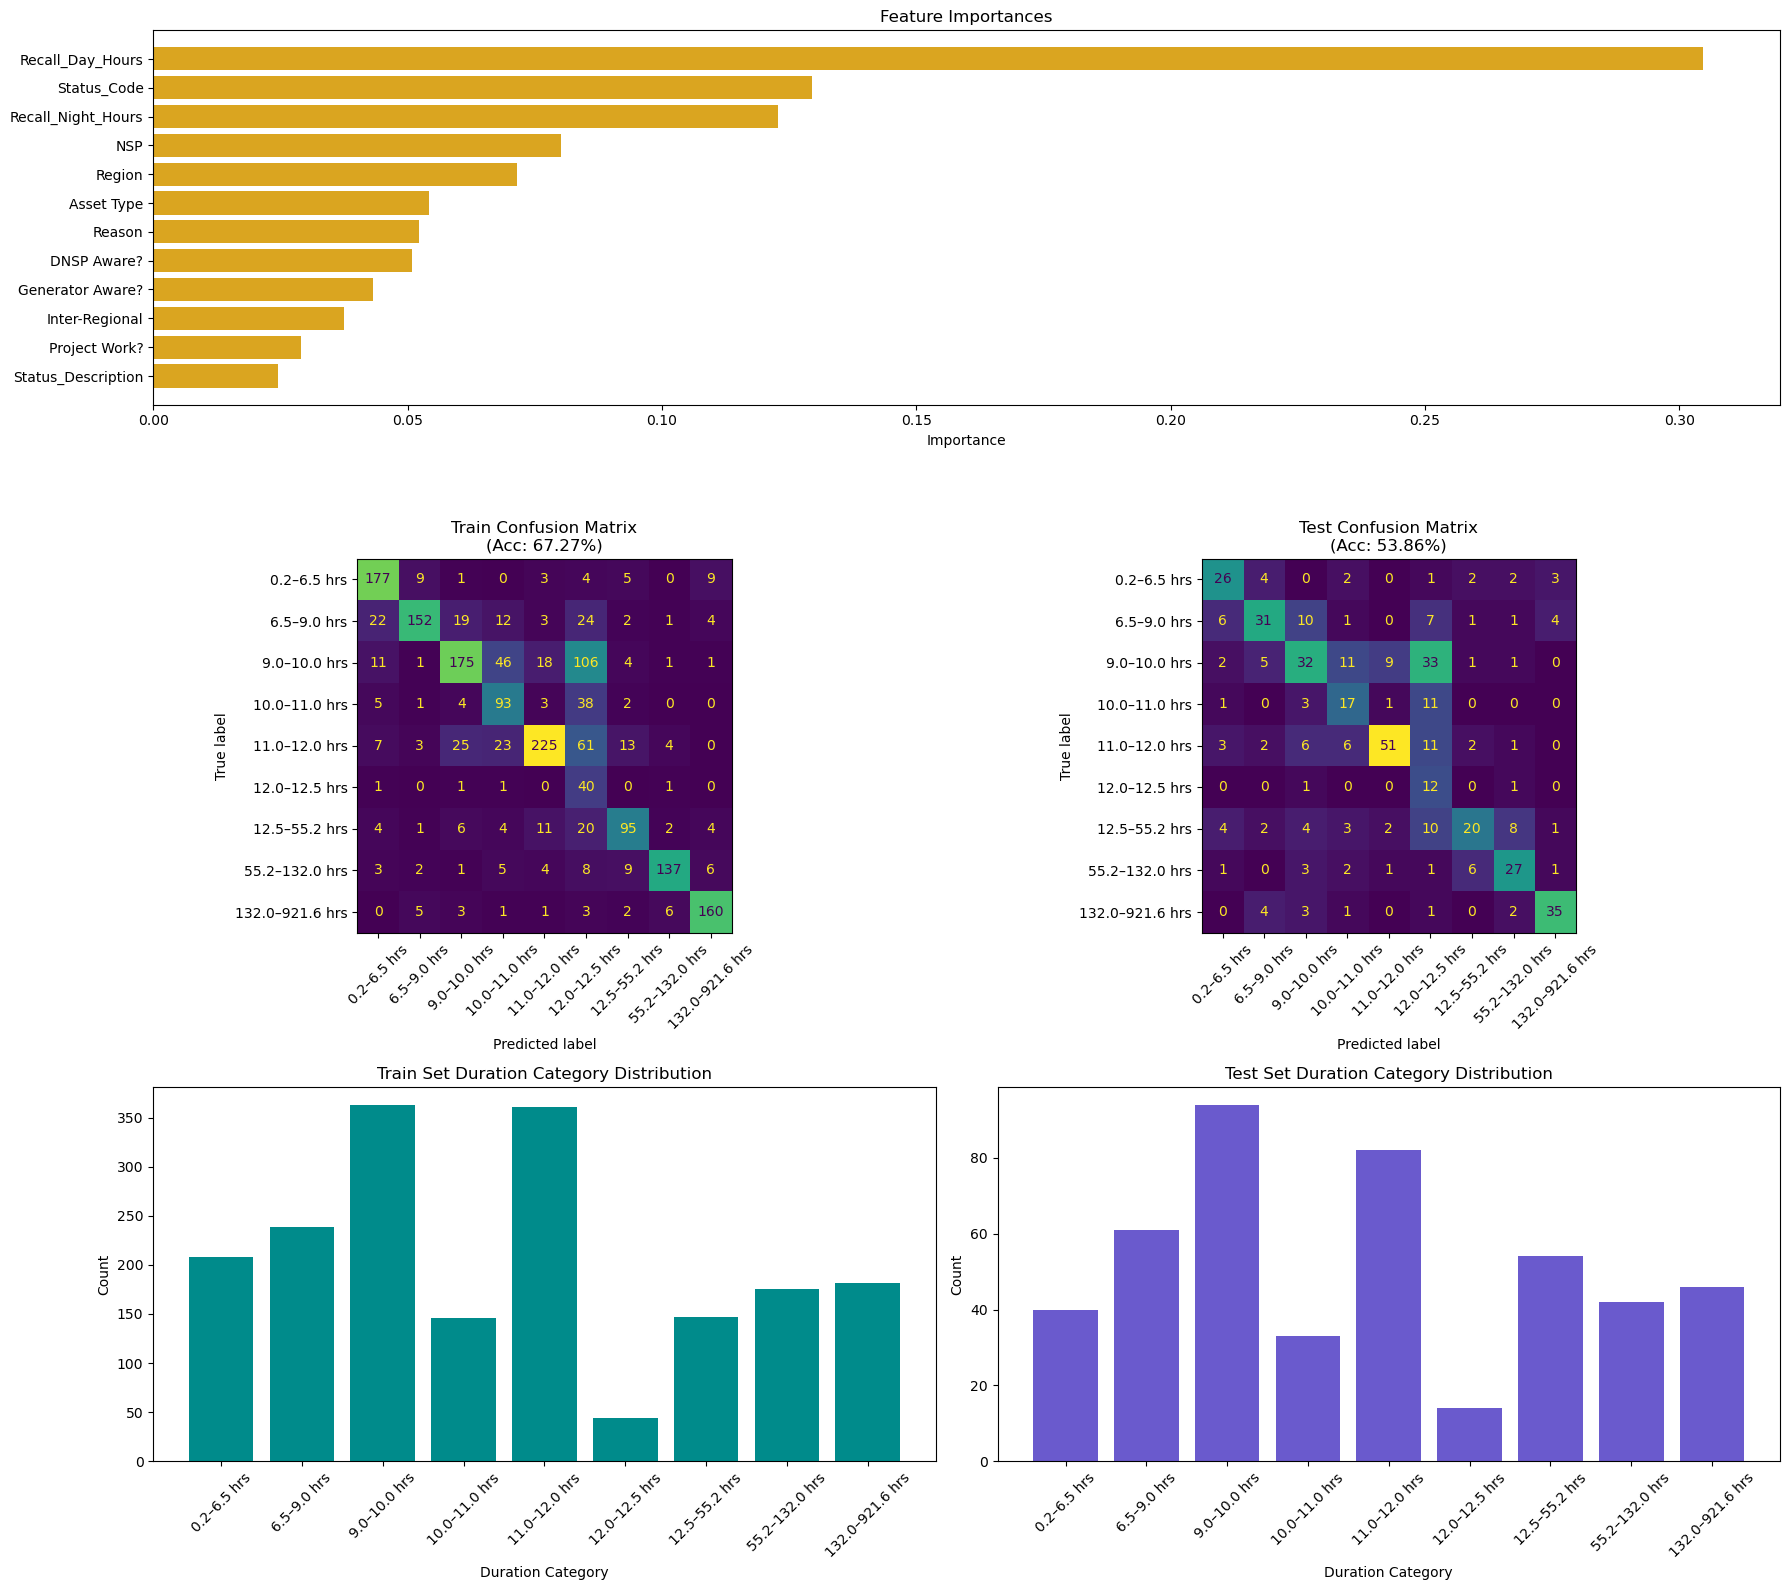

In [5]:
# from data.functions.random_forest_model_and_eval import train_and_evaluate_rf
model = train_and_evaluate_rf(df)

--- Region: SA ---
Classification Report (Test Set):
                 precision    recall  f1-score   support

    0.2–6.5 hrs       0.57      0.31      0.40        13
    6.5–9.0 hrs       0.00      0.00      0.00         2
  10.0–11.0 hrs       0.00      0.00      0.00         1
  11.0–12.0 hrs       0.43      0.75      0.55         4
  12.5–55.2 hrs       0.36      0.42      0.38        12
 55.2–132.0 hrs       0.30      0.50      0.38         6
132.0–921.6 hrs       1.00      0.90      0.95        20

       accuracy                           0.57        58
      macro avg       0.38      0.41      0.38        58
   weighted avg       0.61      0.57      0.57        58



c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


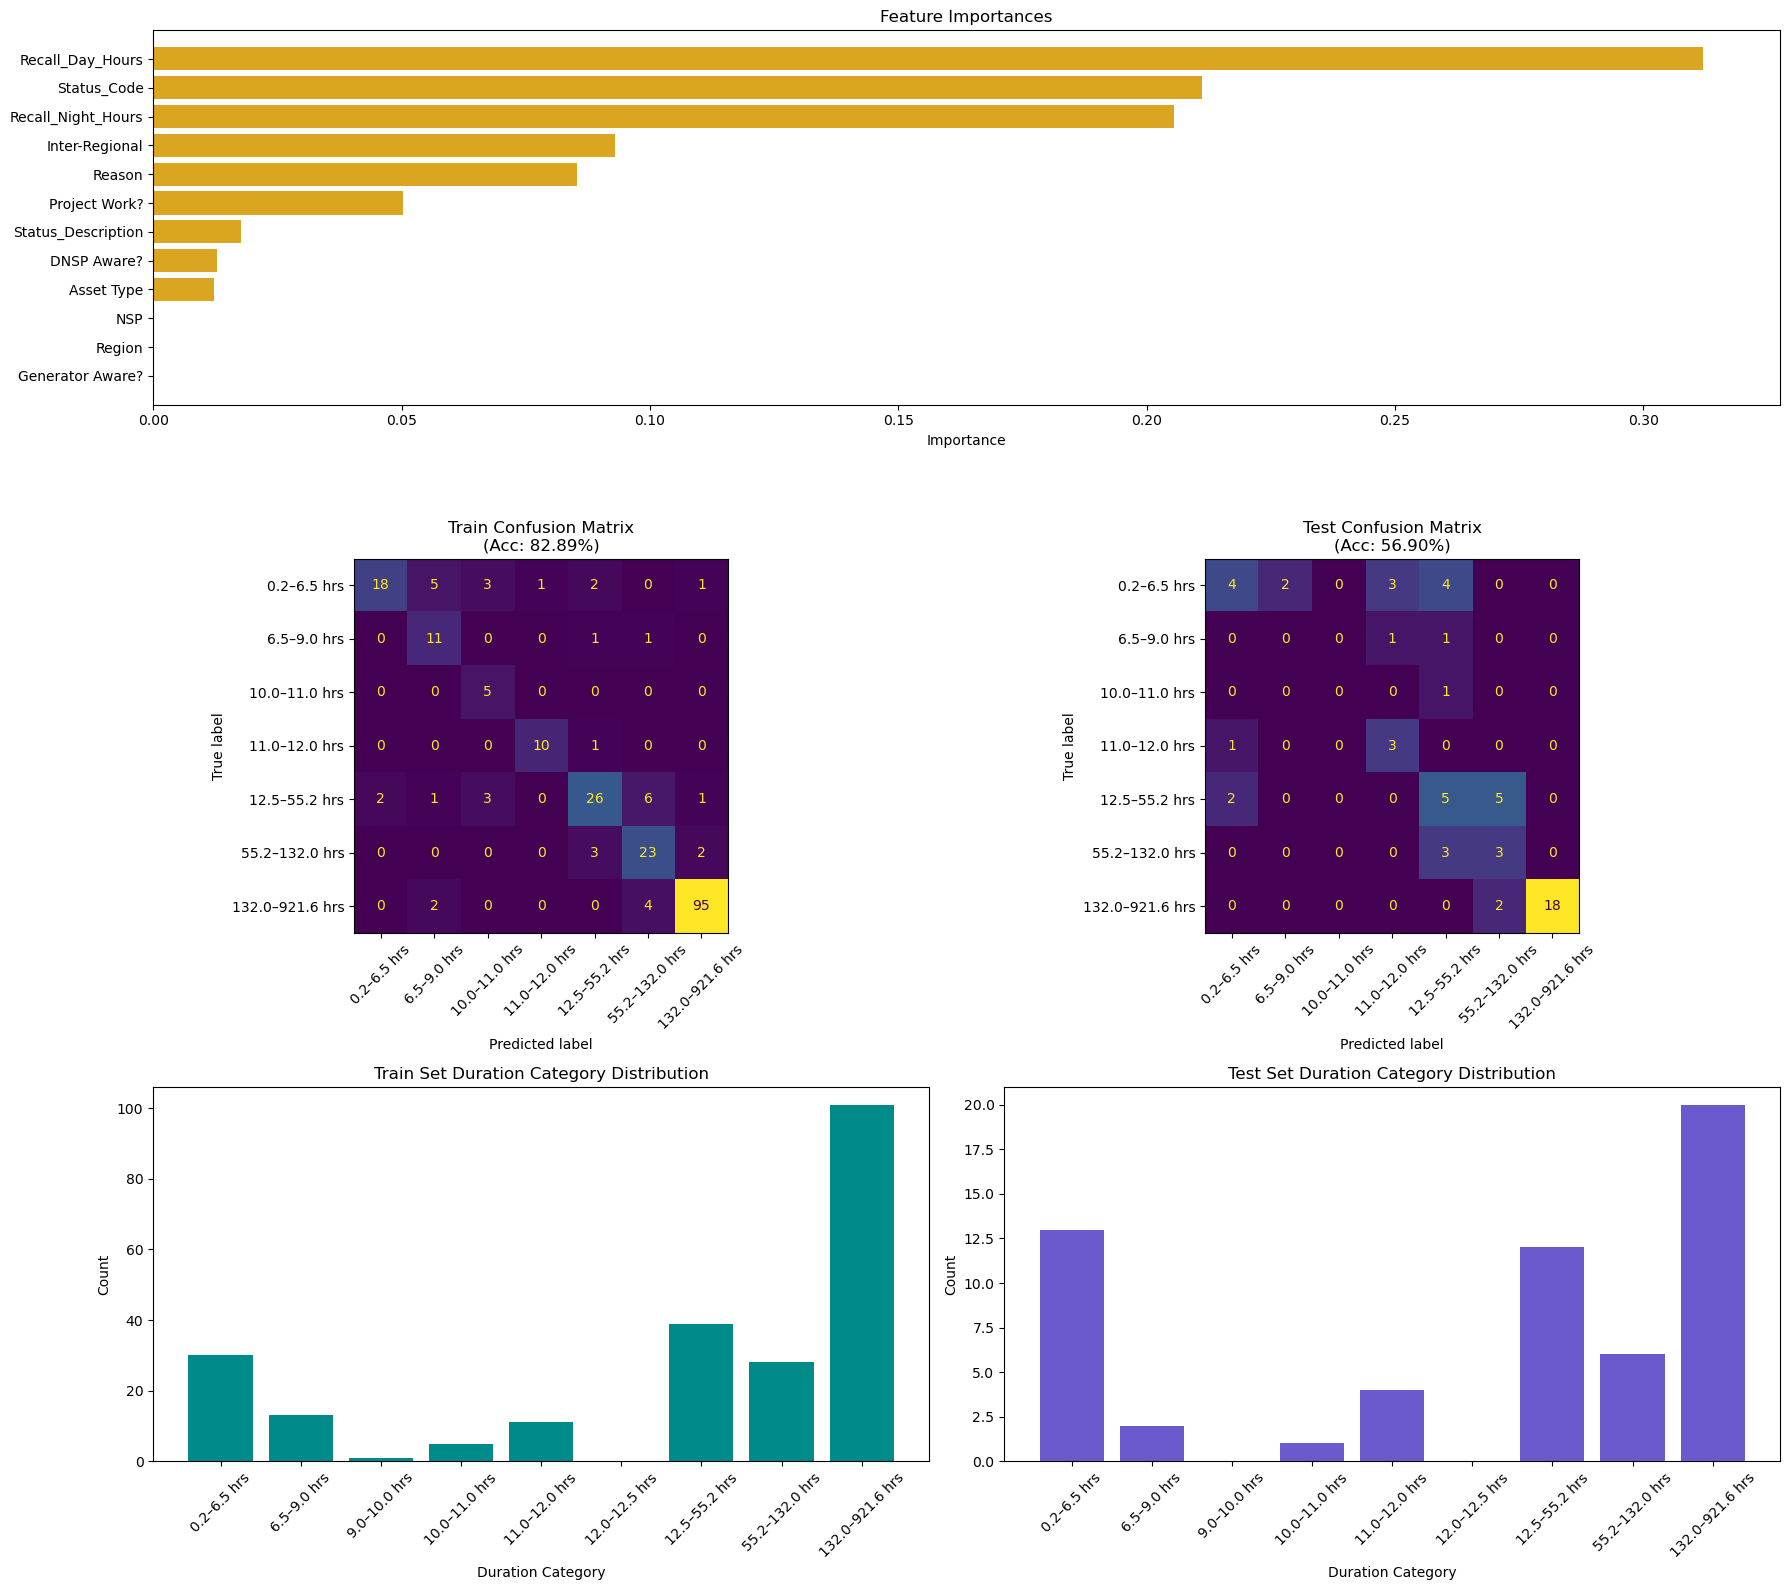

--- Region: VIC ---
Classification Report (Test Set):
                 precision    recall  f1-score   support

    0.2–6.5 hrs       0.38      0.67      0.48        12
    6.5–9.0 hrs       0.00      0.00      0.00        15
   9.0–10.0 hrs       0.53      0.28      0.37        71
  10.0–11.0 hrs       0.41      0.54      0.46        24
  11.0–12.0 hrs       0.88      0.50      0.64        90
  12.0–12.5 hrs       0.07      0.50      0.12         8
  12.5–55.2 hrs       0.41      0.47      0.44        15
 55.2–132.0 hrs       0.43      0.46      0.44        13
132.0–921.6 hrs       0.18      0.67      0.29         3

       accuracy                           0.42       251
      macro avg       0.36      0.45      0.36       251
   weighted avg       0.57      0.42      0.46       251



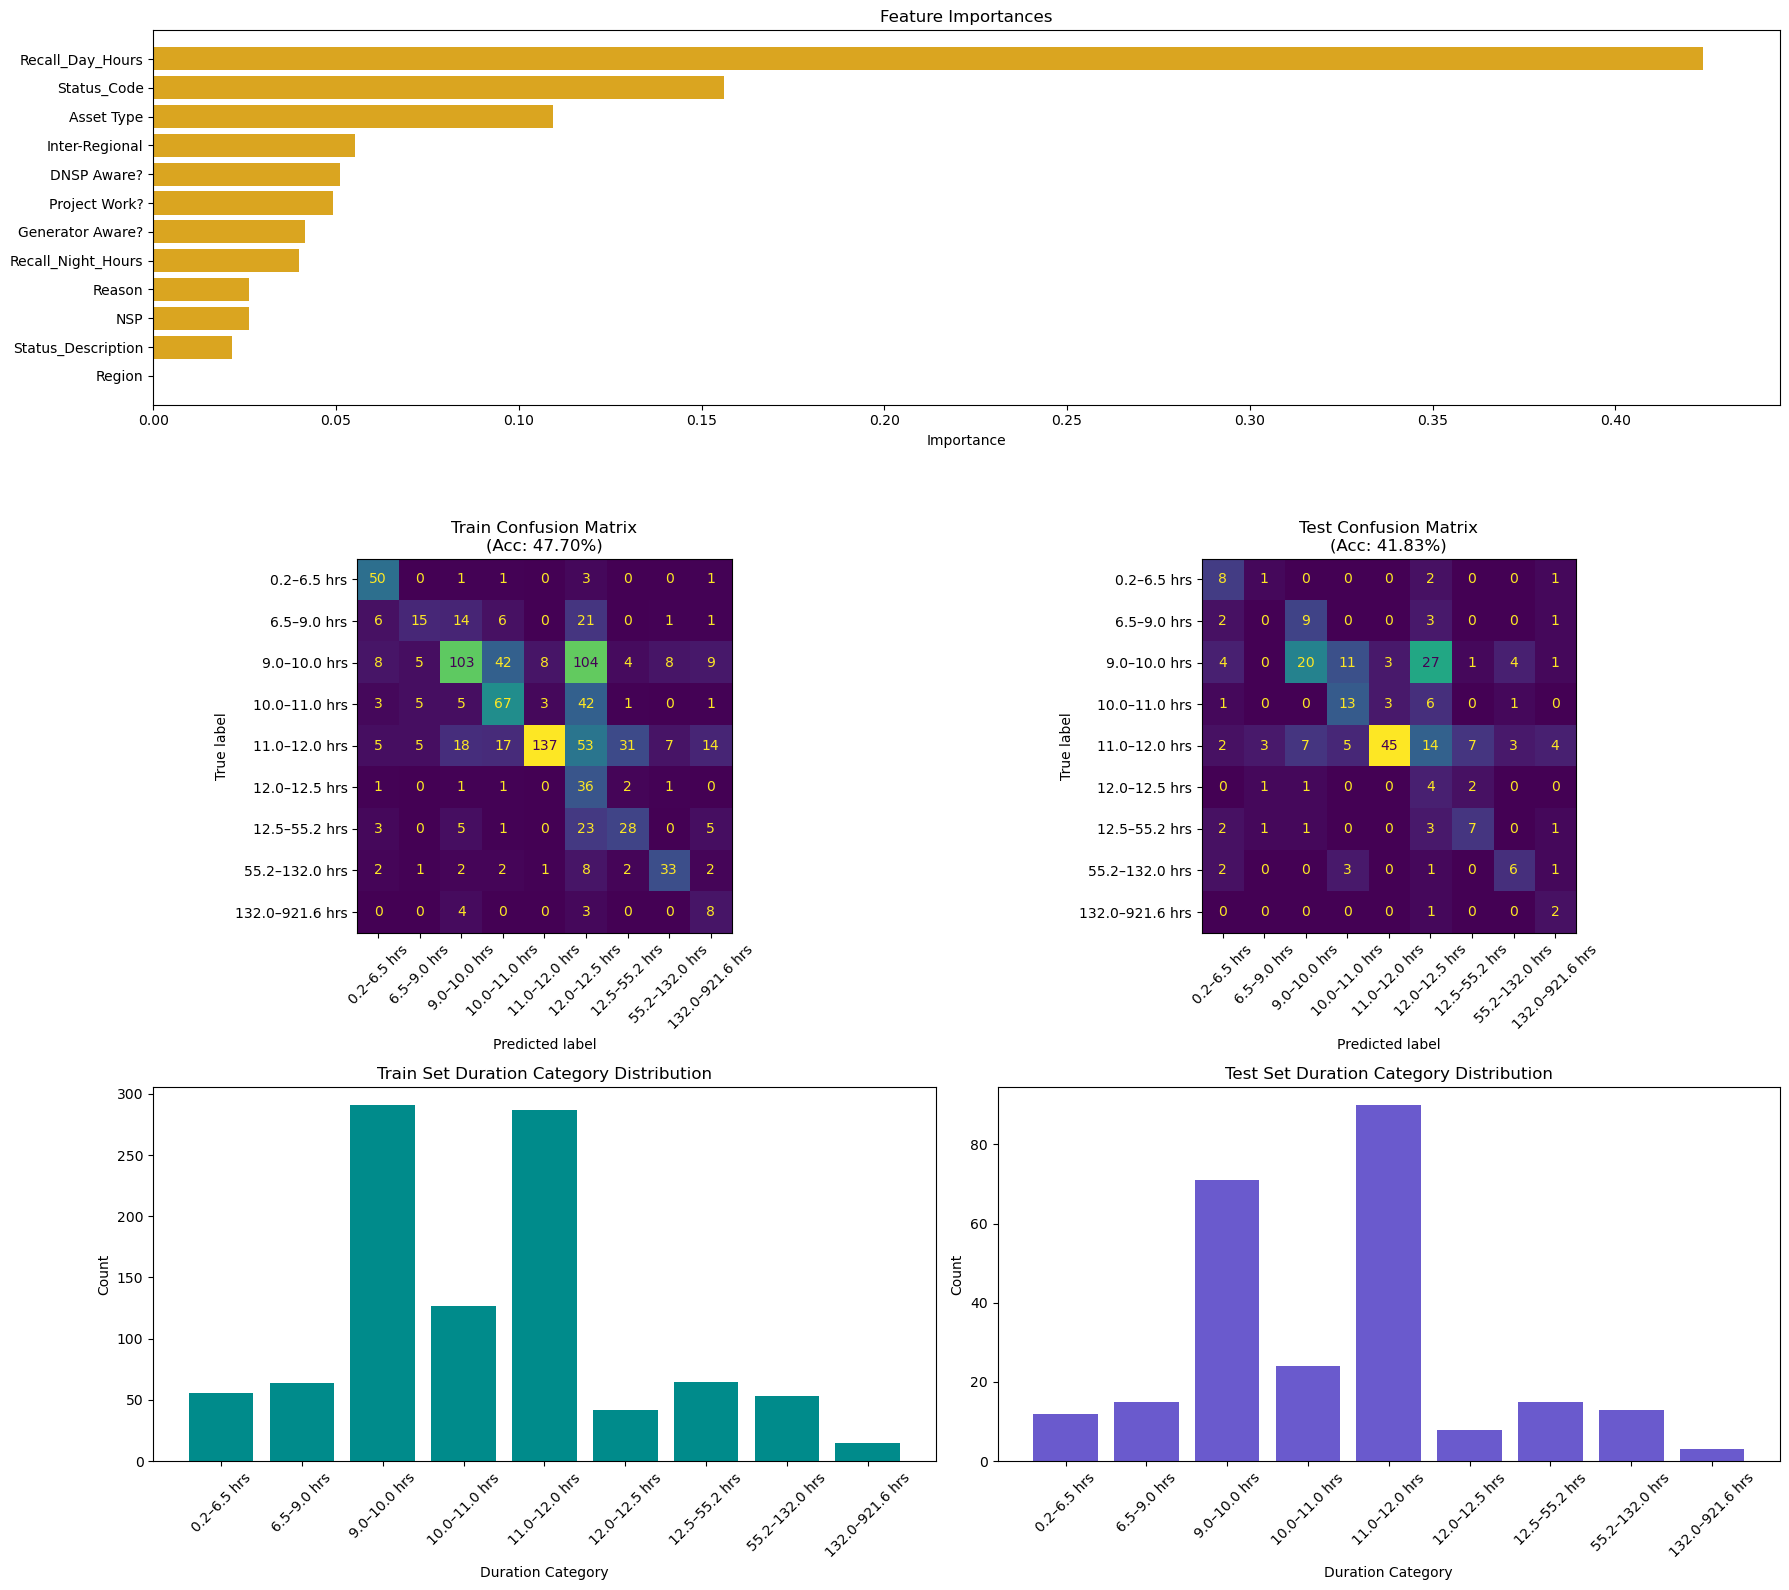

--- Region: TAS ---
Classification Report (Test Set):
                 precision    recall  f1-score   support

    0.2–6.5 hrs       0.58      0.78      0.67         9
    6.5–9.0 hrs       0.75      0.67      0.71         9
  12.5–55.2 hrs       1.00      1.00      1.00         1
 55.2–132.0 hrs       1.00      0.75      0.86         8
132.0–921.6 hrs       0.00      0.00      0.00         2

      micro avg       0.71      0.69      0.70        29
      macro avg       0.67      0.64      0.65        29
   weighted avg       0.72      0.69      0.70        29



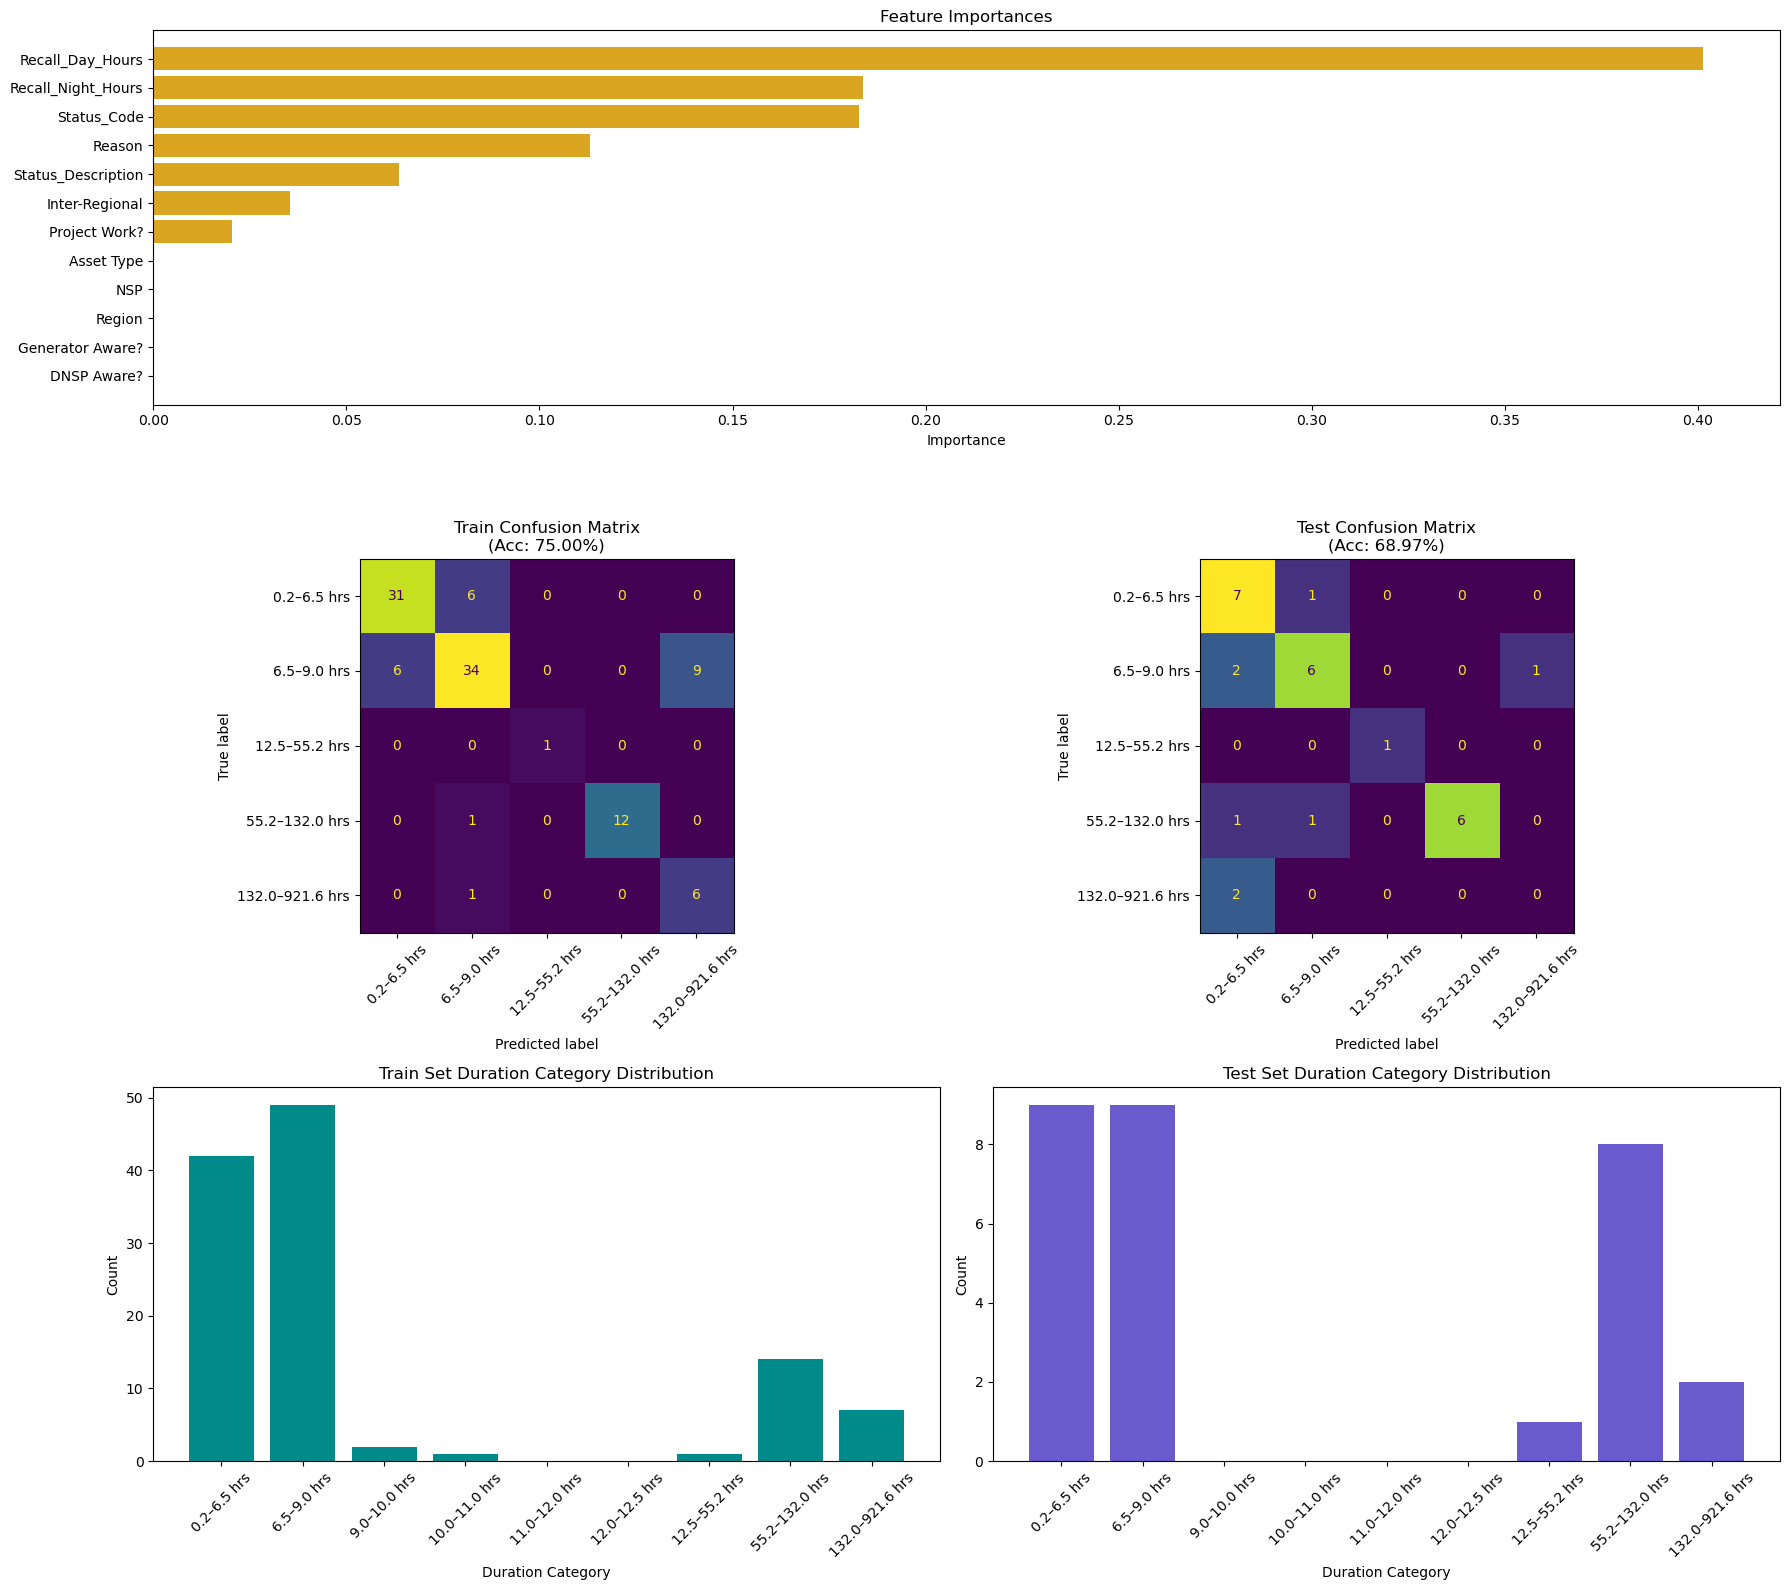

--- Region: QLD ---
Classification Report (Test Set):


c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\althi\anaconda3_2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                 precision    recall  f1-score   support

    0.2–6.5 hrs       0.70      0.70      0.70        10
    6.5–9.0 hrs       0.78      0.67      0.72        27
   9.0–10.0 hrs       0.40      0.33      0.36         6
  10.0–11.0 hrs       0.00      0.00      0.00         1
  12.5–55.2 hrs       0.33      0.67      0.44         6
 55.2–132.0 hrs       0.89      0.62      0.73        13
132.0–921.6 hrs       0.64      0.69      0.67        13

      micro avg       0.66      0.63      0.64        76
      macro avg       0.54      0.52      0.52        76
   weighted avg       0.69      0.63      0.65        76



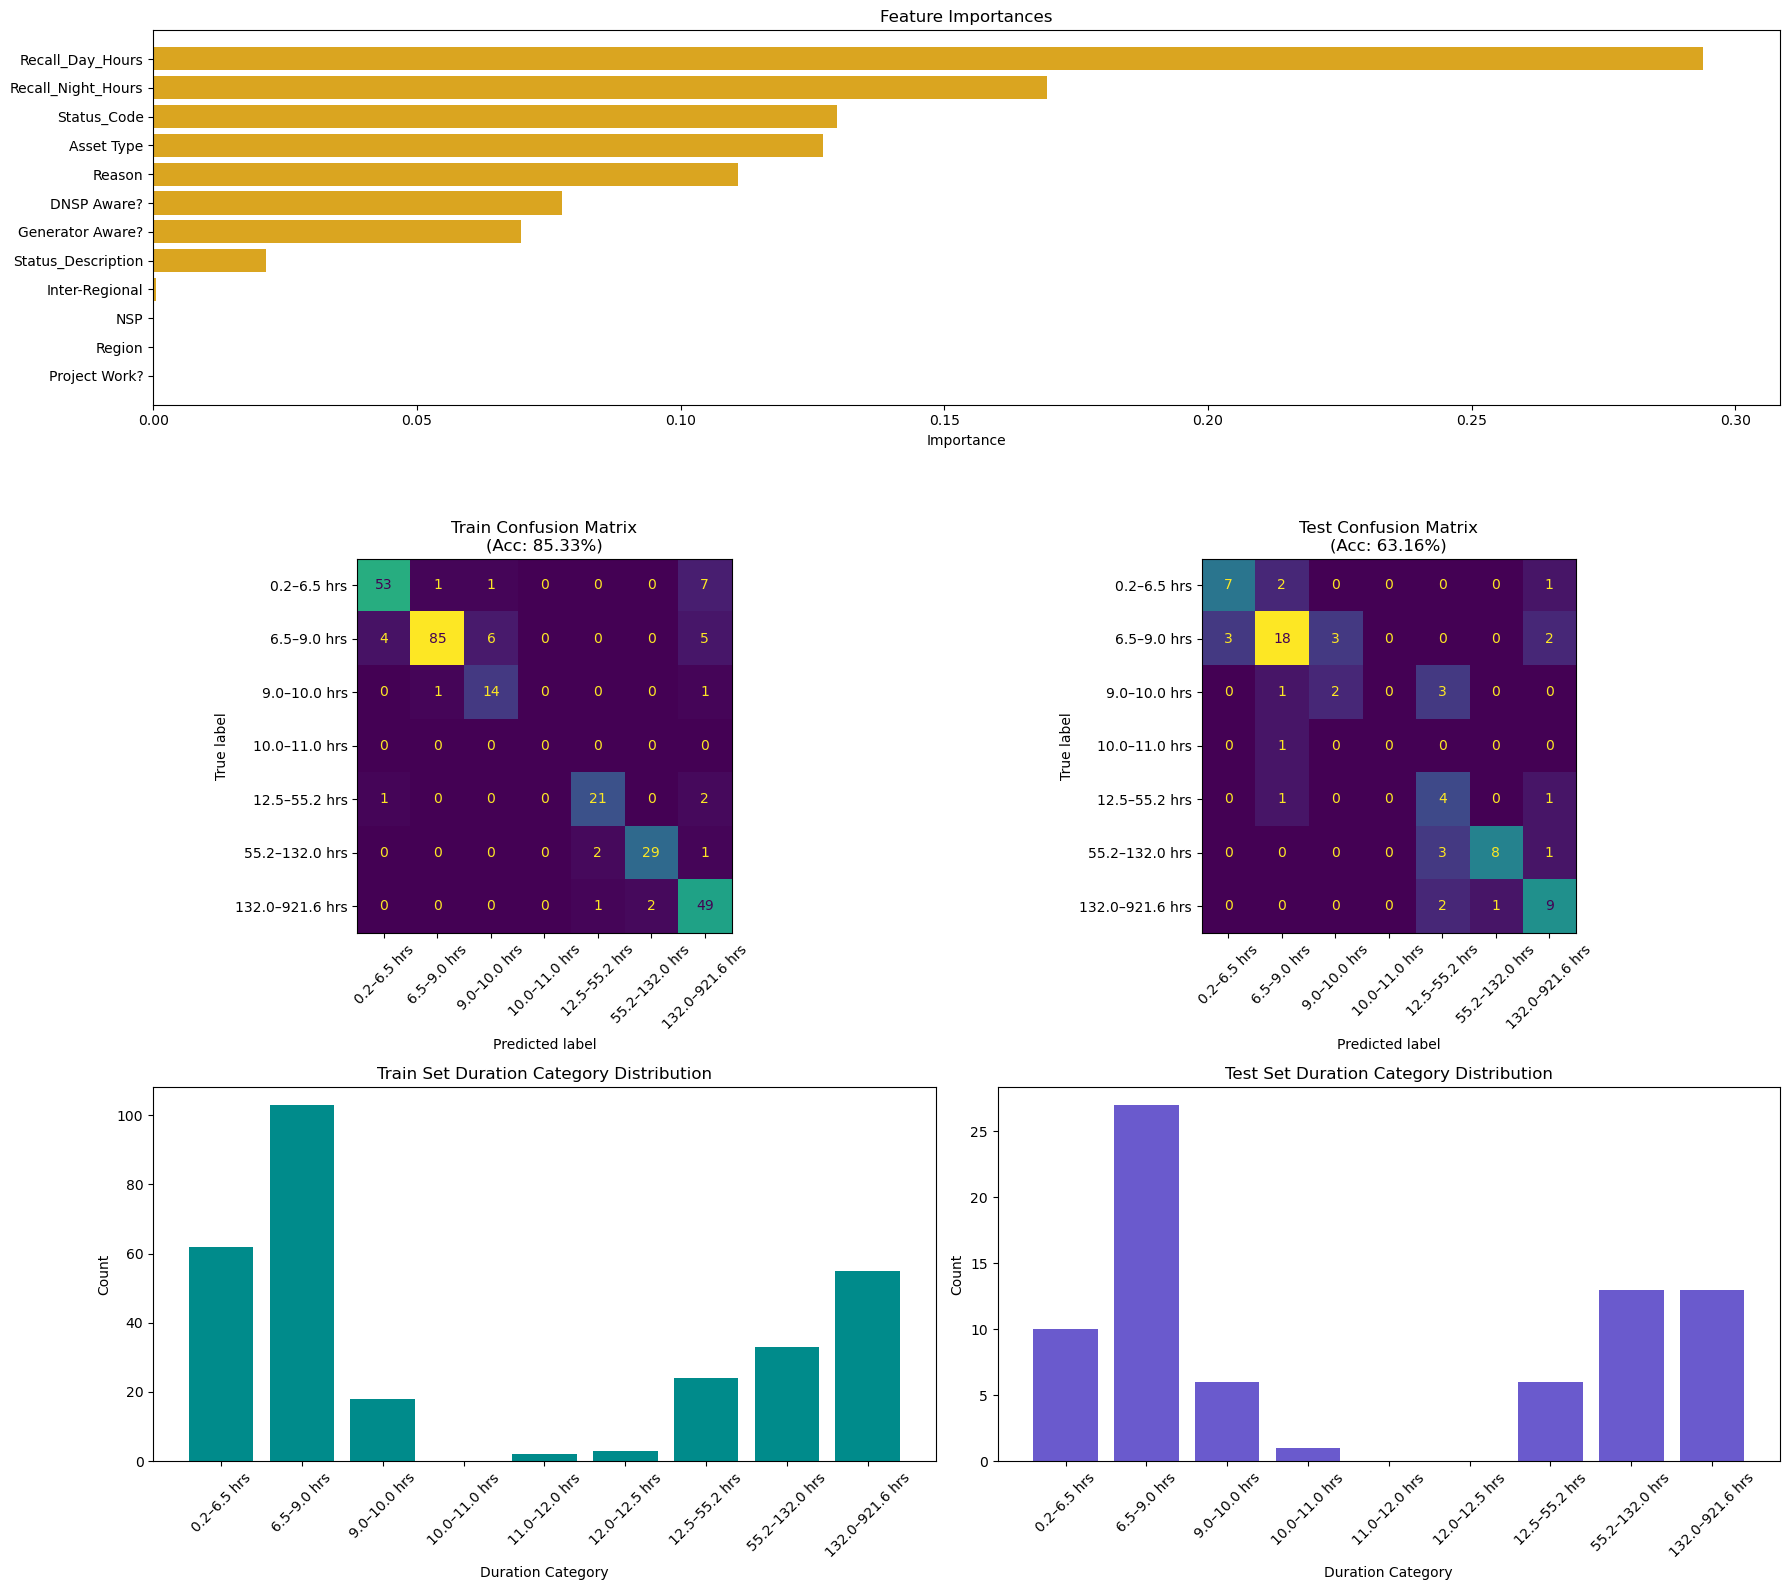

--- Region: NSW ---
Classification Report (Test Set):
                 precision    recall  f1-score   support

    0.2–6.5 hrs       0.75      0.75      0.75         4
    6.5–9.0 hrs       0.00      0.00      0.00         2
   9.0–10.0 hrs       0.78      0.64      0.70        11
  10.0–11.0 hrs       1.00      0.33      0.50         3
  11.0–12.0 hrs       0.88      0.70      0.78        10
  12.5–55.2 hrs       0.50      0.56      0.53         9
 55.2–132.0 hrs       0.79      0.73      0.76        15
132.0–921.6 hrs       0.00      0.00      0.00         1

      micro avg       0.65      0.62      0.64        55
      macro avg       0.59      0.46      0.50        55
   weighted avg       0.72      0.62      0.66        55



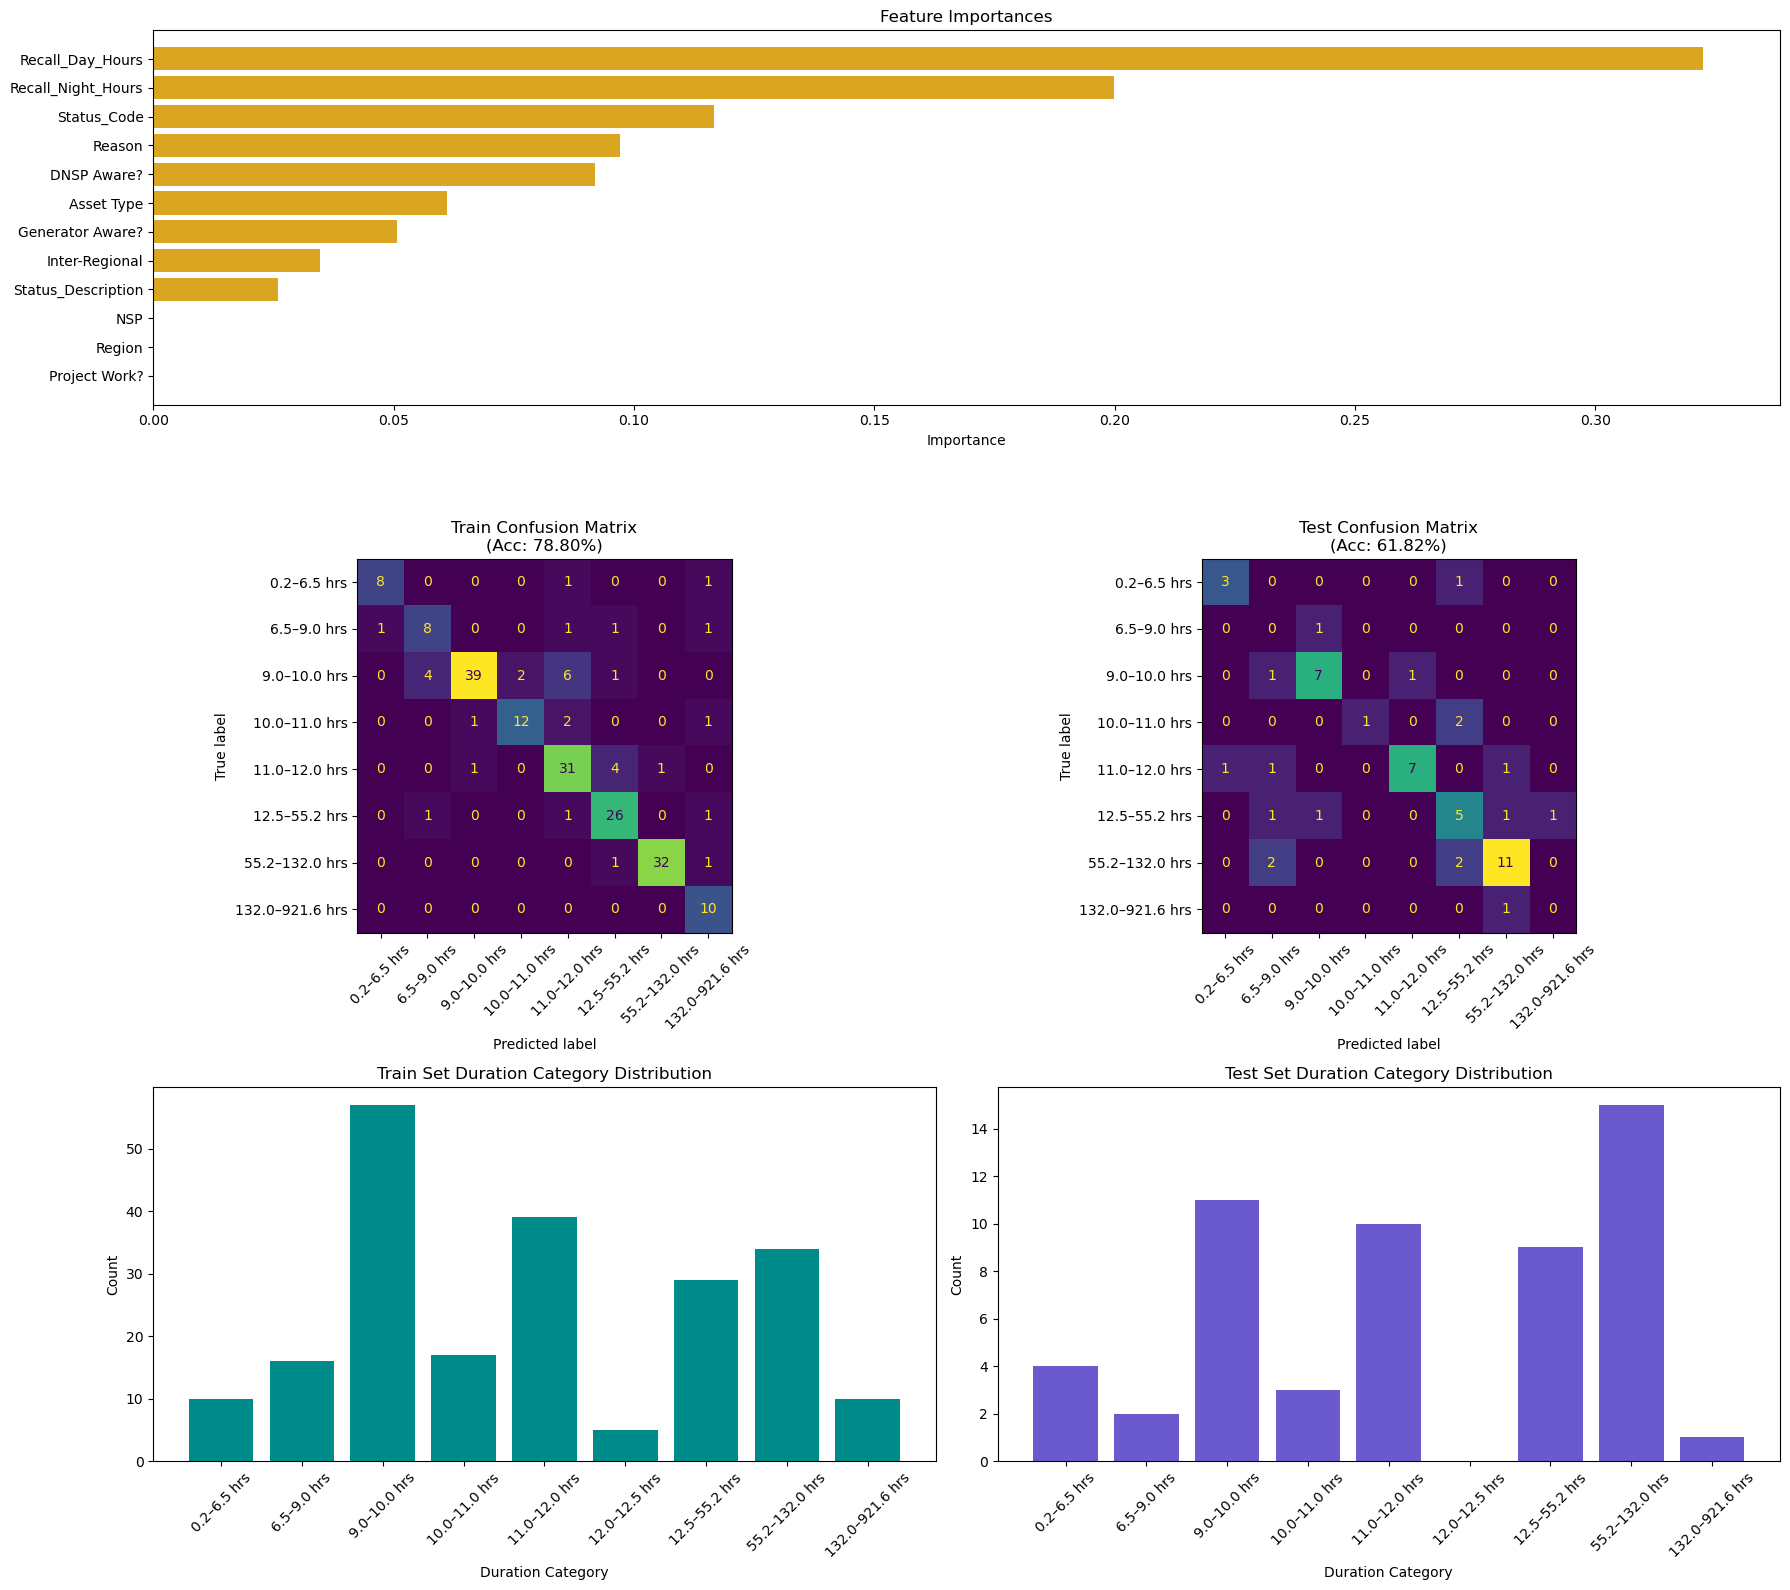

In [6]:
region_models = {}
for region in df['Region'].unique():
    region_df = df[df['Region'] == region].copy()
    print(f"--- Region: {region} ---")
    model = train_and_evaluate_rf(region_df)
    region_models[region] = model